In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os 
import sys

In [2]:
import glob

In [3]:
# 1. where is the LagTraj data??
rootdir = '/data/xchen/lagtraj_atomic/data'
trajdir = os.path.join(rootdir, 'trajectories')
forcingdir = os.path.join(rootdir, 'forcings')

# get a list of files in each directory:
NCFiles =dict()
NCFiles['traj'] = glob.glob(trajdir + '/*.nc')
NCFiles['forcings'] = glob.glob(forcingdir + '/*.nc')



In [4]:
testFN = NCFiles['traj'][0]
print(testFN)

/data/xchen/lagtraj_atomic/data/trajectories/ATOMIC_RHB_2020-02-07_2020-02-08.nc


In [5]:
# 2. read trajectory and forcing files:
num_files = len(NCFiles['traj'])
ds_traj = [None] * num_files
for i in range(num_files):
    thisFN = NCFiles['traj'][i]
    ds_traj[i] = xr.open_dataset(thisFN)

In [6]:
# number of forcing files should be the same as the number of trajectory files
ds_forcings = [None] * num_files
for i in range(num_files):
    thisFN = NCFiles['forcings'][i]
    ds_forcings[i] = xr.open_dataset(thisFN)

In [7]:
ds_traj[i].time[0].values.astype('datetime64[h]')

numpy.datetime64('2020-02-11T22','h')

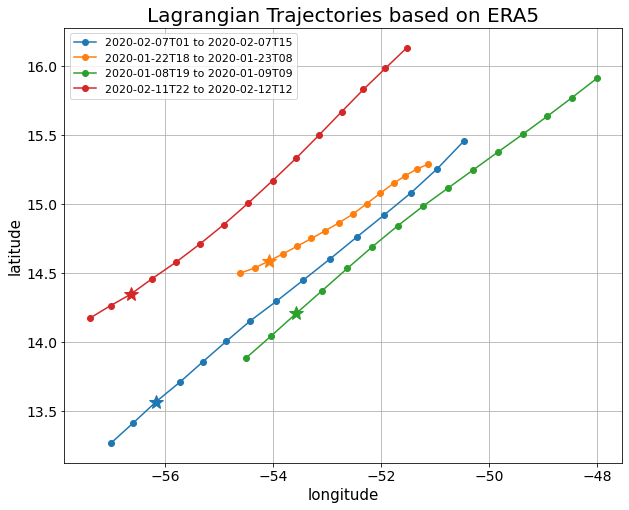

In [9]:
# 3. plot trajectories:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# do they have similar trajectories?
fig, ax = plt.subplots(1,1, figsize=(10,8))
for i in range(num_files):
    label_str = str(ds_traj[i].time[0].values.astype('datetime64[h]')) + ' to ' + str(ds_traj[i].time[-1].values.astype('datetime64[h]'))
    hl=ax.plot(ds_traj[i].lon, ds_traj[i].lat,'-',marker='o', label=label_str)
    # highlight origin.
    lncolor = hl[0].get_color()
    ax.plot(ds_traj[i].origin_lon, ds_traj[i].origin_lat, '*', color=lncolor,markersize=15)
plt.legend()
ax.set_xlabel('longitude', fontsize=15)
ax.set_ylabel('latitude', fontsize=15)
plt.title('Lagrangian Trajectories based on ERA5', fontsize=20)
plt.grid(True)
fig.savefig('Trajs_days_with_SWC.jpg')

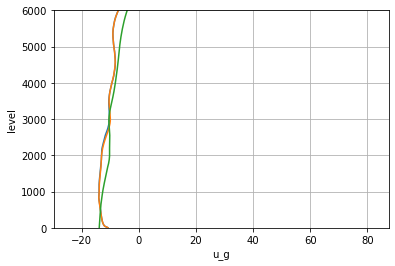

In [51]:
# 3. plot initial conditions (averaged along trajectory (upstream of the starting point))
ds_forcings[0]
# variables of interest:
# t_local: trajectory-centered Temperature  --> need to convert to potential temperature for SAM's use
# theta_local: trajectory-centered potential temperature
# q_local: trajectory-centered specific humidity 
# u_local: 
# v_local:
# w_local:
# o3_local:
# mttlwrcs_local: 


# theta_mean: sampling-domain mean potential temperature
# t_mean:
# q_mean:
# u_mean:
# v_mean:
# w_mean:
# w_corr: corrected vertical velocity?
# ug
# vg
# mttlwrcs_mean: mean temperature tendency due to long wave radiation clear sky
# dudt_adv, dvdt_adv: two advection terms
# dthetadt_adv:
# dq_tdt_adv:
# dr_vdt_adv

# mean in time
ds_forcings[0].u_local.mean(axis=0).plot(y='level')
ds_forcings[0].u_mean.mean(axis=0).plot(y='level')
ds_forcings[0].u_g.mean(axis=0).plot(y='level')
plt.ylim(0,6000)
#plt.xlim(275,400)
plt.grid(True)


In [17]:
# compute the ensemble average of theta and q:
init_vars=['theta_mean','q_mean','u_mean','v_mean']
nlev = len(ds_forcings[0].level)
ensem_initial = dict()
for v in init_vars:
    ensem_initial[v] = np.zeros(nlev)



In [18]:
lsf_vars = ['dthetadt_adv','dr_vdt_adv','u_g','v_g','w_corr_mean']  #'dudt_adv', 'dvdt_adv'
ensem_forcing = dict()
for v in lsf_vars:
    ensem_forcing[v] = np.zeros(nlev)

In [19]:
# merge the different datasets and then average them all...
dsf_all = xr.concat([ds_forcings[ii] for ii in range(num_files)],'time')


In [20]:
for v in init_vars:
    ensem_initial[v] = dsf_all[v].mean(axis=0)
    # this needs to be save to a netCDF file at the end.

In [21]:
for v in lsf_vars:
    ensem_forcing[v] = dsf_all[v].mean(axis=0)

In [22]:
ensem_initial['level'] = dsf_all.level
zmask = dsf_all.level<=6000

In [23]:
vlim = dict()

vlim['theta_mean'] = [295, 330]
vlim['q_mean'] = [0, 0.016]
vlim['u_mean'] = [-20, 20]
vlim['v_mean'] = [-15, 15]
vlim['u_g'] = [-20, 20]
vlim['v_g'] = [-15, 15]


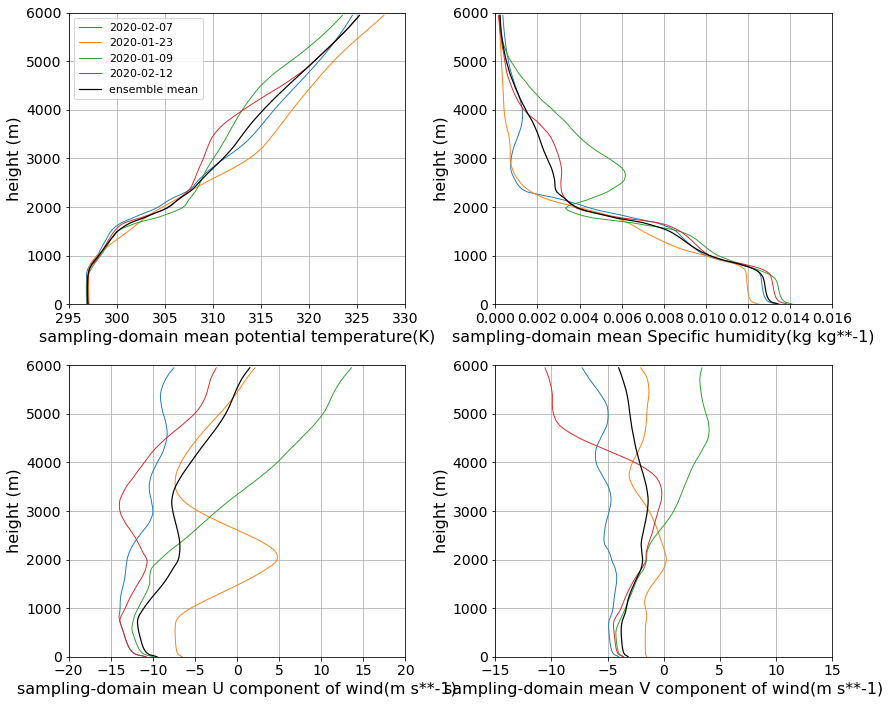

In [32]:
# start here to plot the background sounding:
# 1. plot each day's average condition along track:
fig, axs = plt.subplots(2,2, figsize=(12,10))
# plot theta, q, u, v profiles up to 6km
for ax, v in zip(axs.flatten(), init_vars):
    # plotting the individual profile:
    for ii in range(num_files):
        ds = ds_forcings[ii].where(ds_forcings[ii].level<=6000, drop=True)
        labelstr = str(ds_traj[ii].origin_datetime.values.astype('datetime64[D]'))
        ax.plot(ds[v].mean(axis=0), ds.level, label=labelstr, linewidth=0.95)
        
    # add the averaged value:
    ax.plot(ensem_initial[v][zmask], ensem_initial['level'][zmask], '-k', label='ensemble mean',linewidth=1.2)
    varn = ds[v].long_name
    units = ds[v].units
    ax.set_xlabel(varn + '(' + units +')')
    ax.set_ylabel('height (m)')
    ax.set_ylim(0,6000)
    ax.set_xlim(vlim[v][0], vlim[v][1])
    
    if v=='theta_mean':
        ax.legend()
    ax.grid(True)
    
fig.tight_layout()
fig.savefig('Initial_sndings_days_with_SWC.jpg')
# 2. plot the ensemble averages of all the 4 days:

# 3. 


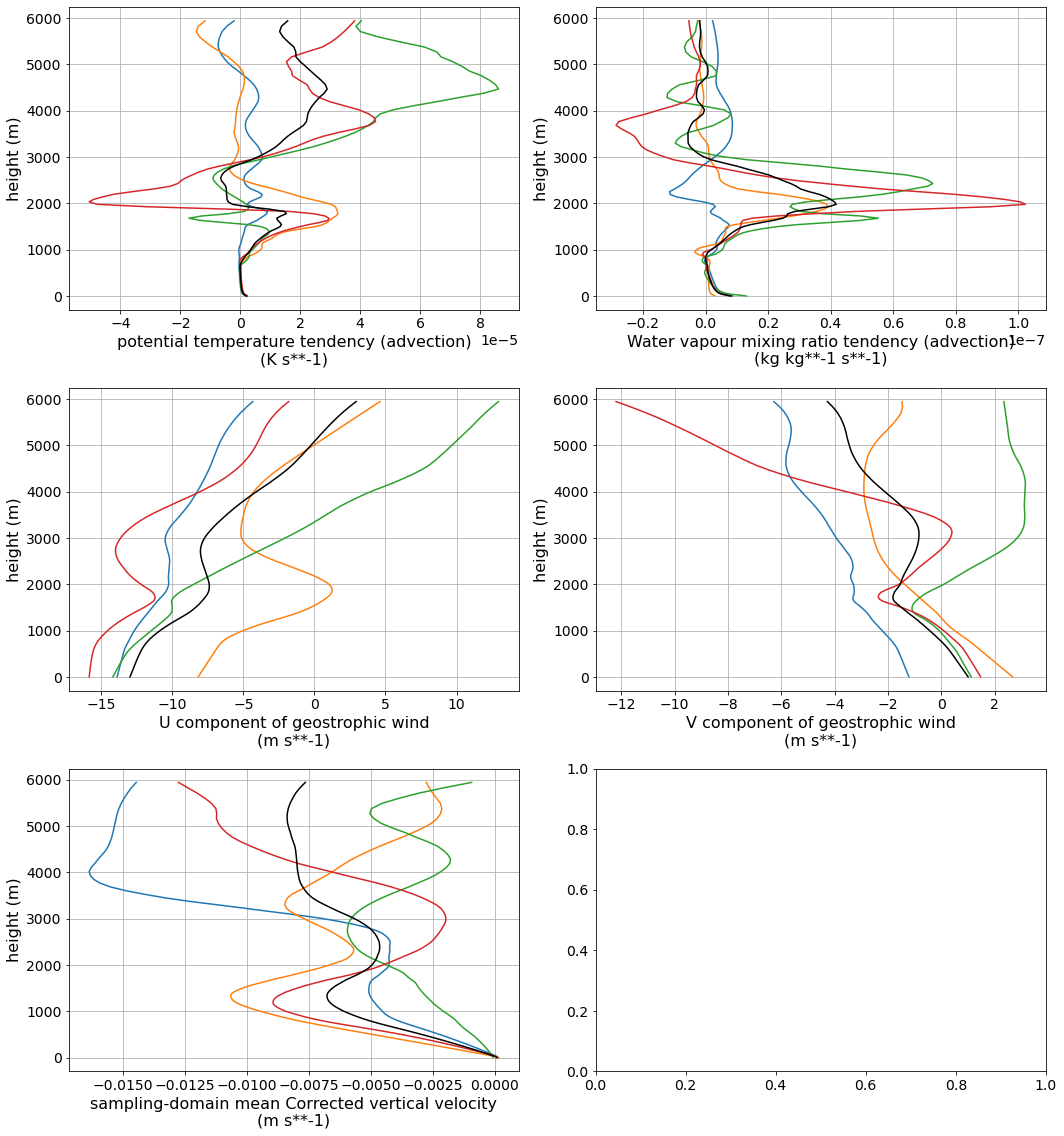

In [47]:
# now, let's take a look at the forcing profiles:
# tendency of temperature, humidty (advection) and u, v (advection); and w.
# let me confirm this with Ping-Ping:
fig, axs = plt.subplots(3,2, figsize=(15,16))
# plot theta, q, u, v profiles up to 6km
for ax, v in zip(axs.flatten(), lsf_vars):
    # plotting the individual profile:
    for ii in range(num_files):
        ds = ds_forcings[ii].where(ds_forcings[ii].level<=6000, drop=True)
        labelstr = str(ds_traj[ii].origin_datetime.values.astype('datetime64[D]'))
        ax.plot(ds[v].mean(axis=0), ds.level, label=labelstr)
        
    # add the averaged value:
    ax.plot(ensem_forcing[v][zmask], ensem_initial['level'][zmask], '-k', label='ensemble mean')
    varn = ds[v].long_name
    units = ds[v].units
    ax.set_xlabel(varn +'\n(' + units +')')
    ax.set_ylabel('height (m)')
    #ax.set_ylim(0,6000)
    #ax.set_xlim(vlim[v][0], vlim[v][1])
    
    if v=='theta_mean':
        ax.legend()
    ax.grid(True)
    
fig.tight_layout()
fig.savefig('Forcings_days_with_SWC.jpg')

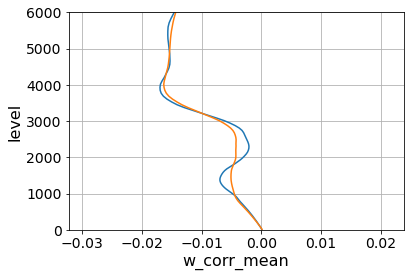

In [28]:
ds_forcings[0].w_corr_local.mean(axis=0).plot(y='level')
ds_forcings[0].w_corr_mean.mean(axis=0).plot(y='level')  # m/s
plt.ylim(0,6000)
plt.grid(True)

(0.0, 6000.0)

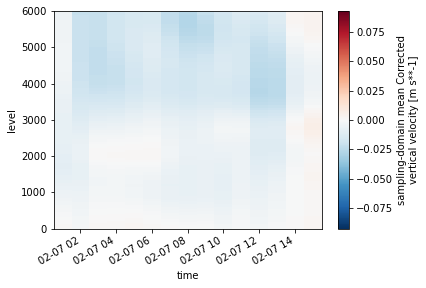

In [60]:
ds_forcings[0].w_corr_mean.plot(y='level')
plt.ylim(0,6000)

In [50]:
ds_forcings[0]
# 4. plot forcings (tendency term.)

<xarray.Dataset>
Dimensions:                (level: 250, time: 15)
Coordinates:
  * time                   (time) datetime64[ns] 2020-02-07T01:00:00 ... 2020...
  * level                  (level) float64 0.0 20.0 40.33 ... 7.08e+04 7.2e+04
Data variables: (12/249)
    lat                    (time) float64 15.46 15.26 15.08 ... 13.42 13.27
    lon                    (time) float64 -50.47 -50.96 -51.44 ... -56.58 -56.99
    u_traj                 (time) float64 -14.71 -14.64 -14.96 ... -12.67 -12.35
    v_traj                 (time) float64 -6.081 -5.415 -4.967 ... -4.828 -4.588
    t_local                (time, level) float64 297.9 297.8 ... 204.4 201.9
    etadot_local           (time, level) float64 1.027e-08 ... -2.028e-10
    ...                     ...
    dtheta_ldy             (time, level) float64 -1.683e-06 ... -8.862e-05
    u_g                    (time, level) float64 -15.3 -15.27 ... 15.65 21.55
    v_g                    (time, level) float64 -0.3299 -0.3708 ... -7.816
    origin_lon             float64 -56.16
    origin_lat             float64 13.57
    origin_datetime        datetime64[ns] 2020-02-07T13:00:00
Attributes: (12/57)
    trajectory_type:                                        lagrangian
    velocity_method:                                        single_height_level
    velocity_method_kwargs_height:                          700.0
    domain_conventions:                                     CF-1.7
    domain_contact:                                         l.c.denby[at]leed...
    domain_era5_reference:                                  Hersbach, H., Bel...
    ...                                                     ...
    trajectory_version:                                     1.0.0
    sampling_method_gradient_method:                        regression
    sampling_method_advection_velocity_sampling_method:     domain_mean
    sampling_method_averaging_width:                        2.0
    sampling_method_time_sampling_method:                   domain_data
    sampling_method_mask:                                   ocean_only